In [18]:
from keras import backend as K
K.clear_session()

In [92]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath("../")
sys.path.append(ROOT_DIR)  # To find local version of the libraryand

from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

import mammo_baseline_pathology

%matplotlib inline 
# Comment out to reload imported modules if they change
%load_ext autoreload
%autoreload 2

# Directory to save logs and trained model
LOGS_DIR = os.path.join(ROOT_DIR, "mammography/checkpoints")

# Dataset directory
DATASET_DIR = os.path.join(ROOT_DIR, "dataset/mammo_all")
print(ROOT_DIR)
print(LOGS_DIR)
print(DATASET_DIR)

print(time.strftime('%Y-%m-%d' , time.localtime()))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/liujing/liuyibo/Mammo_MaskRCNN
/home/liujing/liuyibo/Mammo_MaskRCNN/mammography/checkpoints
/home/liujing/liuyibo/Mammo_MaskRCNN/dataset/mammo_all
2019-05-25


In [20]:
# Comment out to reload imported modules if they change
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
class NoResizeConfig(mammo_baseline_pathology.MammoConfig):
    BACKBONE = "resnet101"
#     IMAGE_RESIZE_MODE = "none"
#     USE_MINI_MASK = False

    #　
    DETECTION_MIN_CONFIDENCE = 0.9 # May19    original 0.7    classification score threshold
    
    # Adjust depending on your GPU memory
    IMAGES_PER_GPU = 1 # 2
    
    IMAGE_MAX_DIM = 1024

    # Number of classes (including background)
    NUM_CLASSES = 1 + 2  # Background + Malignant + Benign

    # Number of training and validation steps per epoch
#     STEPS_PER_EPOCH = (len(dataset_train.image_ids)) // IMAGES_PER_GPU
#     VALIDATION_STEPS = max(1, len(dataset_val.image_ids) // IMAGES_PER_GPU)
    
    MINI_MASK_SHAPE = (56, 56)  # (height, width) of the mini-mask
    RPN_ANCHOR_SCALES = (32, 64, 128, 256, 512)
    RPN_TRAIN_ANCHORS_PER_IMAGE = 512
    RPN_ANCHOR_RATIOS = [0.5, 1, 2]
    
    # ROIs kept after non-maximum supression (training and inference)
    POST_NMS_ROIS_TRAINING = 2000
    POST_NMS_ROIS_INFERENCE = 1000
    
    # Non-max suppression threshold to filter RPN proposals.
    # You can increase this during training to generate more propsals.
    RPN_NMS_THRESHOLD = 0.7
    
config = NoResizeConfig()
# config = mammo_baseline_pathology.MammoInferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTA

In [74]:
# dataset
dataset = mammo_baseline_pathology.MammoDataset()
dataset.load_mammo(DATASET_DIR, "mass_test", augmented=False, json_filename="mammo_all_ddsm_mass_test.json") # test
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

mass_test
Images: 361
Classes: ['BG', 'MALIGNANT', 'BENIGN']


In [59]:
DEVICE = "/gpu:0"  # 0
TEST_MODE = "inference"

# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference",
                              model_dir=LOGS_DIR,
                              config=config)

In [67]:
# load weights
weights_path = 'checkpoints/mammo_pathology20190520T0003/mask_rcnn_mammo_pathology_0050.h5'
print("Loading weights:", weights_path)
time_now = time.time()
model.load_weights(weights_path, by_name=True) 
print("Weights loaded")

Loading weights: checkpoints/mammo_pathology20190520T0003/mask_rcnn_mammo_pathology_0050.h5
Re-starting from epoch 50
Weights loaded


In [75]:
# run model
gt_li = []
pred_li = []
for image_id in dataset.image_ids: # test
    # Load image
    print('loading image', image_id)
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
    # Run object detection
    print('running detection')
    results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0) # verbose=0
    
    gt_li.append((image, image_meta, gt_class_id, gt_bbox, gt_mask))
    pred_li.append(results)

loading image 0
running detection
loading image 1
running detection
loading image 2
running detection
loading image 3
running detection
loading image 4
running detection
loading image 5
running detection
loading image 6
running detection
loading image 7
running detection
loading image 8
running detection
loading image 9
running detection
loading image 10
running detection
loading image 11
running detection
loading image 12
running detection
loading image 13
running detection
loading image 14
running detection
loading image 15
running detection
loading image 16
running detection
loading image 17
running detection
loading image 18
running detection
loading image 19
running detection
loading image 20
running detection
loading image 21
running detection
loading image 22
running detection
loading image 23
running detection
loading image 24
running detection
loading image 25
running detection
loading image 26
running detection
loading image 27
running detection
loading image 28
running detec

running detection
loading image 232
running detection
loading image 233
running detection
loading image 234
running detection
loading image 235
running detection
loading image 236
running detection
loading image 237
running detection
loading image 238
running detection
loading image 239
running detection
loading image 240
running detection
loading image 241
running detection
loading image 242
running detection
loading image 243
running detection
loading image 244
running detection
loading image 245
running detection
loading image 246
running detection
loading image 247
running detection
loading image 248
running detection
loading image 249
running detection
loading image 250
running detection
loading image 251
running detection
loading image 252
running detection
loading image 253
running detection
loading image 254
running detection
loading image 255
running detection
loading image 256
running detection
loading image 257
running detection
loading image 258
running detection
loading im

In [26]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    fig, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    fig.tight_layout()
    return ax

In [86]:
def compute_sensitivity(gt_li, pred_li):
    iou_threshold = 0.1
    cnt = 0
    cnt_mismatch = 0
    total_obj = 0
    detected_obj = 0
    tp = 0
    fp = 0
    fn = 0
    tn = 0
    overlap_n = 0
    overlap_sum = 0
    
    detect_sen = -1
    confusion_matrix = -1
    avg_overlap = -1
    
    for item in zip(gt_li, pred_li): # for one image
        gt, pred = item
        image, image_meta, gt_class_id, gt_bbox, gt_mask = gt
        
        results = pred
        r = results[0]
        
        cnt += 1
        print('\nimg:', cnt)
        print('\nrois', r['rois'], '\nclass_ids', r['class_ids'], '\nscores', r['scores'], '\nmasks', r['masks'].shape)
        print('\ngt_bbox', gt_bbox, '\ngt_class_id', gt_class_id, '\ngt_mask', gt_mask.shape)
        
        # match
#         gt_match, pred_match, overlaps = utils.compute_proposal_matches(gt_bbox, gt_class_id, gt_mask,
#                                                                r['rois'], r['class_ids'], r['scores'], r['masks'],
#                                                                iou_threshold=0.1, score_threshold=0.9) # 0.5, 0.9
#         print('\ngt_match', gt_match, '\npred_match', pred_match, '\noverlaps', overlaps)
        
        # evaluation
        if gt_mask.shape[:-1] == r['masks'].shape[:-1]:
            all_mask_iou = utils.compute_overlaps_masks(r['masks'], gt_mask)
        else: 
            print('shape mismatch:', gt_mask.shape, r['masks'].shape)
            cnt_mismatch += 1
            continue
        total_obj += len(gt_bbox)
        all_roi_iou = utils.compute_overlaps(r['rois'], gt_bbox)
        print('roi_iou', all_roi_iou)
        print('mask_iou', all_mask_iou)
        
        for i in range(len(all_roi_iou)):
            for j in range(len(all_roi_iou[0])):
                roi_iou = all_roi_iou[i][j]
                if roi_iou > iou_threshold:
                    detected_obj += 1
                
                    # classification
                    if r['class_ids'][i] == 1 and gt_class_id[j] == 1:
                        tp += 1
                    elif r['class_ids'][i] == 1 and gt_class_id[j] == 2:
                        fp += 1
                    elif r['class_ids'][i] == 2 and gt_class_id[j] == 1:
                        fn += 1
                    elif r['class_ids'][i] == 2 and gt_class_id[j] == 2:
                        tn += 1
                
                    # mask iou
                    mask_iou =  all_mask_iou[i][j]
                    overlap_n += 1
                    overlap_sum += mask_iou
                else:
                    continue
                    
#         # show differences
#         if cnt < 20:
#             try:
#                 visualize.display_differences(image, gt_bbox, gt_class_id, gt_mask, r['rois'], r['class_ids'], r['scores'], r['masks'],
#                                       dataset.class_names, ax=get_ax(),show_box=True, show_mask=True,
#                                       iou_threshold=0.1, score_threshold=0.9) # iou threshold =0.5
#             except:
#                 print('visualization error')
#                 continue

    try:
        detect_sen = detected_obj/total_obj
        confusion_matrix = (tp, fp, fn, tn)
        avg_overlap = overlap_sum/overlap_n
    except:
        print('devision error')
    print('cnt_mismatch:', cnt_mismatch)
    
    return detect_sen, confusion_matrix, avg_overlap

detect_sen, confusion_matrix, avg_overlap = compute_sensitivity(gt_li, pred_li)     
print(detect_sen, confusion_matrix, avg_overlap)
        


img: 1

rois [[248 434 305 495]] 
class_ids [2] 
scores [0.99991536] 
masks (1024, 1024, 1)

gt_bbox [[250 437 312 492]] 
gt_class_id [2] 
gt_mask (1024, 1024, 1)
roi_iou [[0.78327292]]
mask_iou [[0.7652976]]

img: 2

rois [] 
class_ids [] 
scores [] 
masks (1024, 1024, 0)

gt_bbox [[430 417 466 448]] 
gt_class_id [1] 
gt_mask (1024, 1024, 1)
roi_iou []
mask_iou [[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]

img: 3

rois [[229 646 353 764]] 
class_ids [1] 
scores [0.9961054] 
masks (1024, 1024, 1)

gt_bbox [[249 653 363 761]] 
gt_class_id [1] 
gt_mask (1024, 1024, 1)
roi_iou [[0.71486762]]
mask_iou [[0.5671921]]

img: 4

rois [[437 422 531 509]
 [316 495 358 538]] 
class_ids [1 2] 
scores [0.90502274 0.8208254 ] 
masks (1024, 1024, 2)

gt_bbox [[306 486 366 553]] 
gt_class_id [2] 
gt_mask (1024, 1024, 1)
roi_iou [[0.        ]
 [0.44925373]]
mask_iou [[0.        ]
 [0.36683416]]

img: 5

rois [[389 422 432 472]] 
class_ids [2] 
scores [0.7727815] 
masks (1024, 1024, 1)

gt_bbox [[331 365 3

roi_iou [[0.69496843]
 [0.        ]]
mask_iou [[0.6314158]
 [0.       ]]

img: 45

rois [[652 731 706 772]] 
class_ids [2] 
scores [0.7652537] 
masks (1024, 1024, 1)

gt_bbox [[442 637 478 686]] 
gt_class_id [2] 
gt_mask (1024, 1024, 1)
roi_iou [[0.]]
mask_iou [[0.]]

img: 46

rois [[302 759 396 841]
 [448 680 558 783]
 [686 798 746 845]] 
class_ids [1 1 2] 
scores [0.91387606 0.76584595 0.751144  ] 
masks (1024, 1024, 3)

gt_bbox [[442 675 535 773]] 
gt_class_id [2] 
gt_mask (1024, 1024, 1)
roi_iou [[0.       ]
 [0.6549826]
 [0.       ]]
mask_iou [[0.        ]
 [0.48658007]
 [0.        ]]

img: 47

rois [[578 342 619 389]
 [  0 221 107 373]] 
class_ids [2 1] 
scores [0.90304655 0.87134427] 
masks (1024, 1024, 2)

gt_bbox [[583 348 620 388]] 
gt_class_id [2] 
gt_mask (1024, 1024, 1)
roi_iou [[0.73207931]
 [0.        ]]
mask_iou [[0.84438777]
 [0.        ]]

img: 48

rois [[294 584 370 653]
 [427 497 488 557]] 
class_ids [2 1] 
scores [0.9872535 0.9412683] 
masks (1024, 1024, 2)

gt_bbo

roi_iou [[0.         0.8604119  0.        ]
 [0.         0.         0.76712329]
 [0.         0.         0.        ]]
mask_iou [[0.         0.80975956 0.        ]
 [0.         0.         0.6364043 ]
 [0.         0.         0.        ]]

img: 84

rois [[499 602 554 656]
 [513 522 580 601]
 [576 670 623 716]] 
class_ids [2 1 1] 
scores [0.9418514  0.86972326 0.81043667] 
masks (1024, 1024, 3)

gt_bbox [[360 540 464 676]] 
gt_class_id [1] 
gt_mask (1024, 1024, 1)
roi_iou [[0.]
 [0.]
 [0.]]
mask_iou [[0.]
 [0.]
 [0.]]

img: 85

rois [[381 401 441 455]
 [446 340 494 389]
 [775 443 876 554]
 [434 637 506 698]
 [545 605 603 659]
 [598 544 641 592]] 
class_ids [1 1 2 2 2 1] 
scores [0.84162265 0.8361379  0.81845653 0.7887463  0.7880132  0.73034114] 
masks (1024, 1024, 6)

gt_bbox [[622 575 649 599]] 
gt_class_id [2] 
gt_mask (891, 928, 1)
shape mismatch: (891, 928, 1) (1024, 1024, 6)

img: 86

rois [[426 617 493 685]] 
class_ids [1] 
scores [0.99875104] 
masks (1024, 1024, 1)

gt_bbox [[421 610

roi_iou [[0.77411168]
 [0.        ]]
mask_iou [[0.7019737]
 [0.       ]]

img: 118

rois [] 
class_ids [] 
scores [] 
masks (1024, 1024, 0)

gt_bbox [[628 388 695 465]] 
gt_class_id [1] 
gt_mask (1024, 1024, 1)
roi_iou []
mask_iou [[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]

img: 119

rois [[369 469 440 535]
 [462 447 543 524]] 
class_ids [2 1] 
scores [0.7974743  0.71607953] 
masks (1024, 1024, 2)

gt_bbox [[319 468 431 589]] 
gt_class_id [2] 
gt_mask (1024, 1024, 1)
roi_iou [[0.28926905]
 [0.        ]]
mask_iou [[0.18475965]
 [0.        ]]

img: 120

rois [[641 585 761 694]
 [652 586 759 693]
 [402 463 467 513]] 
class_ids [1 2 1] 
scores [0.9789457 0.9078081 0.7427796] 
masks (1024, 1024, 3)

gt_bbox [[658 575 774 699]] 
gt_class_id [2] 
gt_mask (1024, 1024, 1)
roi_iou [[0.69144546]
 [0.71922002]
 [0.        ]]
mask_iou [[0.15320592]
 [0.        ]
 [0.        ]]

img: 121

rois [[229 644 285 694]
 [368 824 418 852]] 
class_ids [2 1] 
scores [0.93425816 0.84894705] 
masks (1024, 1024, 

roi_iou [[0.        ]
 [0.68495118]
 [0.        ]]
mask_iou [[0.       ]
 [0.6249443]
 [0.       ]]

img: 149

rois [[482 287 524 339]] 
class_ids [1] 
scores [0.9229168] 
masks (1024, 1024, 1)

gt_bbox [[478 288 527 345]] 
gt_class_id [1] 
gt_mask (1024, 1024, 1)
roi_iou [[0.75555556]]
mask_iou [[0.769779]]

img: 150

rois [] 
class_ids [] 
scores [] 
masks (1024, 1024, 0)

gt_bbox [[483 548 527 584]] 
gt_class_id [2] 
gt_mask (1024, 1024, 1)
roi_iou []
mask_iou [[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]

img: 151

rois [[684 320 743 398]] 
class_ids [2] 
scores [0.83995473] 
masks (1024, 1024, 1)

gt_bbox [[701 340 744 401]] 
gt_class_id [2] 
gt_mask (1024, 1024, 1)
roi_iou [[0.50866569]]
mask_iou [[0.05926997]]

img: 152

rois [[518 279 648 388]] 
class_ids [1] 
scores [0.9894019] 
masks (1024, 1024, 1)

gt_bbox [[526 263 650 385]] 
gt_class_id [1] 
gt_mask (1024, 1024, 1)
roi_iou [[0.79017475]]
mask_iou [[0.35846952]]

img: 153

rois [] 
class_ids [] 
scores [] 
masks (1024, 1024, 0

roi_iou [[0.72440438]
 [0.        ]]
mask_iou [[0.7214061]
 [0.       ]]

img: 190

rois [] 
class_ids [] 
scores [] 
masks (1024, 1024, 0)

gt_bbox [[588 620 635 661]] 
gt_class_id [2] 
gt_mask (1024, 1024, 1)
roi_iou []
mask_iou [[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]

img: 191

rois [[756 437 792 477]
 [534 621 583 668]] 
class_ids [2 2] 
scores [0.87519085 0.7646052 ] 
masks (1024, 1024, 2)

gt_bbox [[350 521 405 607]] 
gt_class_id [1] 
gt_mask (1024, 1024, 1)
roi_iou [[0.]
 [0.]]
mask_iou [[0.]
 [0.]]

img: 192

rois [] 
class_ids [] 
scores [] 
masks (1024, 1024, 0)

gt_bbox [[447 515 493 557]] 
gt_class_id [1] 
gt_mask (1024, 1024, 1)
roi_iou []
mask_iou [[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]

img: 193

rois [] 
class_ids [] 
scores [] 
masks (1024, 1024, 0)

gt_bbox [[363 516 471 650]] 
gt_class_id [2] 
gt_mask (891, 962, 1)
shape mismatch: (891, 962, 1) (1024, 1024, 0)

img: 194

rois [[541 416 584 464]] 
class_ids [2] 
scores [0.8697512] 
masks (1024, 1024, 1)

gt_bbox [

roi_iou [[0.46458037]
 [0.        ]]
mask_iou [[0.]
 [0.]]

img: 230

rois [[668 803 709 843]] 
class_ids [1] 
scores [0.9979365] 
masks (1024, 1024, 1)

gt_bbox [[670 808 704 837]] 
gt_class_id [1] 
gt_mask (1024, 1024, 1)
roi_iou [[0.60121951]]
mask_iou [[0.72351694]]

img: 231

rois [[503 334 645 457]
 [366 320 439 420]
 [528 324 661 470]] 
class_ids [1 1 2] 
scores [0.9959157  0.95230746 0.82177335] 
masks (1024, 1024, 3)

gt_bbox [[509 329 643 468]] 
gt_class_id [1] 
gt_mask (1024, 1024, 1)
roi_iou [[0.84048955]
 [0.        ]
 [0.72464754]]
mask_iou [[0.4181833]
 [0.       ]
 [0.3117604]]

img: 232

rois [[801 783 857 810]] 
class_ids [2] 
scores [0.94603693] 
masks (1024, 1024, 1)

gt_bbox [[345 571 423 652]] 
gt_class_id [2] 
gt_mask (1024, 1024, 1)
roi_iou [[0.]]
mask_iou [[0.]]

img: 233

rois [[542 448 587 485]
 [616 408 661 458]
 [743 619 815 707]] 
class_ids [2 2 2] 
scores [0.9993787  0.81832016 0.7771497 ] 
masks (1024, 1024, 3)

gt_bbox [[537 446 588 492]] 
gt_class_id [

roi_iou [[0.        ]
 [0.        ]
 [0.03652897]
 [0.        ]
 [0.        ]
 [0.02538915]]
mask_iou [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]

img: 271

rois [[576 353 619 412]
 [531 557 603 630]
 [783 367 832 430]
 [730 482 828 577]] 
class_ids [2 2 2 2] 
scores [0.9308098  0.8493053  0.82225597 0.7146723 ] 
masks (1024, 1024, 4)

gt_bbox [[617 427 669 489]] 
gt_class_id [2] 
gt_mask (1024, 1024, 1)
roi_iou [[0.]
 [0.]
 [0.]
 [0.]]
mask_iou [[0.]
 [0.]
 [0.]
 [0.]]

img: 272

rois [[424 369 479 432]] 
class_ids [1] 
scores [0.8689203] 
masks (1024, 1024, 1)

gt_bbox [[441 398 510 467]] 
gt_class_id [2] 
gt_mask (1024, 1024, 1)
roi_iou [[0.18632824]]
mask_iou [[0.05059591]]

img: 273

rois [[844 362 896 437]
 [843 356 899 435]] 
class_ids [1 2] 
scores [0.95160127 0.7914035 ] 
masks (1024, 1024, 2)

gt_bbox [[836 357 897 428]] 
gt_class_id [2] 
gt_mask (1024, 1024, 1)
roi_iou [[0.71514899]
 [0.77910994]]
mask_iou [[0.64146423]
 [0.6658502 ]]

img: 274

rois [[556 314 596 360]] 
class_ids 

 [0.        ]]
mask_iou [[0.54344195]
 [0.        ]]

img: 314

rois [[ 92 713 127 746]
 [467 606 513 664]
 [574 375 634 439]] 
class_ids [2 2 2] 
scores [0.98609215 0.941812   0.8690276 ] 
masks (1024, 1024, 3)

gt_bbox [[561 370 633 447]] 
gt_class_id [2] 
gt_mask (1024, 1024, 1)
roi_iou [[0.        ]
 [0.        ]
 [0.67332382]]
mask_iou [[0.       ]
 [0.       ]
 [0.5469162]]

img: 315

rois [] 
class_ids [] 
scores [] 
masks (1024, 1024, 0)

gt_bbox [[251 785 320 853]] 
gt_class_id [1] 
gt_mask (1024, 1024, 1)
roi_iou []
mask_iou [[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]

img: 316

rois [[498 427 549 480]] 
class_ids [1] 
scores [0.87667924] 
masks (1024, 1024, 1)

gt_bbox [[494 417 577 506]] 
gt_class_id [1] 
gt_mask (1024, 1024, 1)
roi_iou [[0.36591309]]
mask_iou [[0.42586428]]

img: 317

rois [[154 149 219 212]
 [552 323 616 395]] 
class_ids [1 1] 
scores [0.9684787 0.8183405] 
masks (1024, 1024, 2)

gt_bbox [[232 258 286 339]
 [154 158 194 201]] 
gt_class_id [2 1] 
gt_mask (10

roi_iou [[0. 0.]]
mask_iou [[0. 0.]]

img: 356

rois [] 
class_ids [] 
scores [] 
masks (1024, 1024, 0)

gt_bbox [[219 248 313 302]] 
gt_class_id [1] 
gt_mask (1024, 1024, 1)
roi_iou []
mask_iou [[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]

img: 357

rois [[442 299 492 357]
 [480 548 534 596]] 
class_ids [1 1] 
scores [0.98064137 0.88220733] 
masks (1024, 1024, 2)

gt_bbox [[444 306 490 352]] 
gt_class_id [2] 
gt_mask (1024, 1024, 1)
roi_iou [[0.72965517]
 [0.        ]]
mask_iou [[0.8698023]
 [0.       ]]

img: 358

rois [[657 540 712 604]
 [471 637 522 680]] 
class_ids [2 2] 
scores [0.9646828  0.76428354] 
masks (1024, 1024, 2)

gt_bbox [[459 631 522 682]] 
gt_class_id [2] 
gt_mask (1024, 1024, 1)
roi_iou [[0.        ]
 [0.68253968]]
mask_iou [[0.       ]
 [0.5135259]]

img: 359

rois [] 
class_ids [] 
scores [] 
masks (1024, 1024, 0)

gt_bbox [[427 395 468 435]] 
gt_class_id [2] 
gt_mask (1024, 1024, 1)
roi_iou []
mask_iou [[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]

img: 360

rois [] 
c

['BENIGN', 'BENIGN 1.00 / 0.77']
['MALIGNANT']
['MALIGNANT', 'MALIGNANT 1.00 / 0.57']
['BENIGN', 'MALIGNANT 0.91 / 0.00', 'BENIGN 0.82 / 0.37']
['BENIGN', 'BENIGN 0.77 / 0.00']
['BENIGN', 'MALIGNANT 0.80 / 0.00']
['MALIGNANT', 'MALIGNANT', 'MALIGNANT 0.87 / 0.00', 'MALIGNANT 0.85 / 0.00', 'MALIGNANT 0.83 / 0.00', 'MALIGNANT 0.80 / 0.00']
['BENIGN', 'MALIGNANT 0.94 / 0.00']
['BENIGN', 'MALIGNANT 0.81 / 0.00', 'BENIGN 0.77 / 0.52']
['BENIGN', 'MALIGNANT 0.97 / 0.80']
['MALIGNANT', 'MALIGNANT 0.95 / 0.62', 'MALIGNANT 0.89 / 0.00']
['BENIGN', 'MALIGNANT 0.86 / 0.00', 'BENIGN 0.77 / 0.00', 'MALIGNANT 0.73 / 0.69']
['MALIGNANT', 'MALIGNANT 0.95 / 0.59']
['MALIGNANT', 'MALIGNANT 1.00 / 0.00', 'BENIGN 0.95 / 0.00']
visualization error
['BENIGN', 'BENIGN 0.75 / 0.00', 'BENIGN 0.72 / 0.67', 'MALIGNANT 0.71 / 0.00']
['BENIGN', 'BENIGN 1.00 / 0.61', 'BENIGN 0.97 / 0.00']
['MALIGNANT', 'MALIGNANT 0.99 / 0.72', 'BENIGN 0.89 / 0.00']
['MALIGNANT', 'BENIGN 0.97 / 0.79', 'MALIGNANT 0.79 / 0.78', 'BENIG

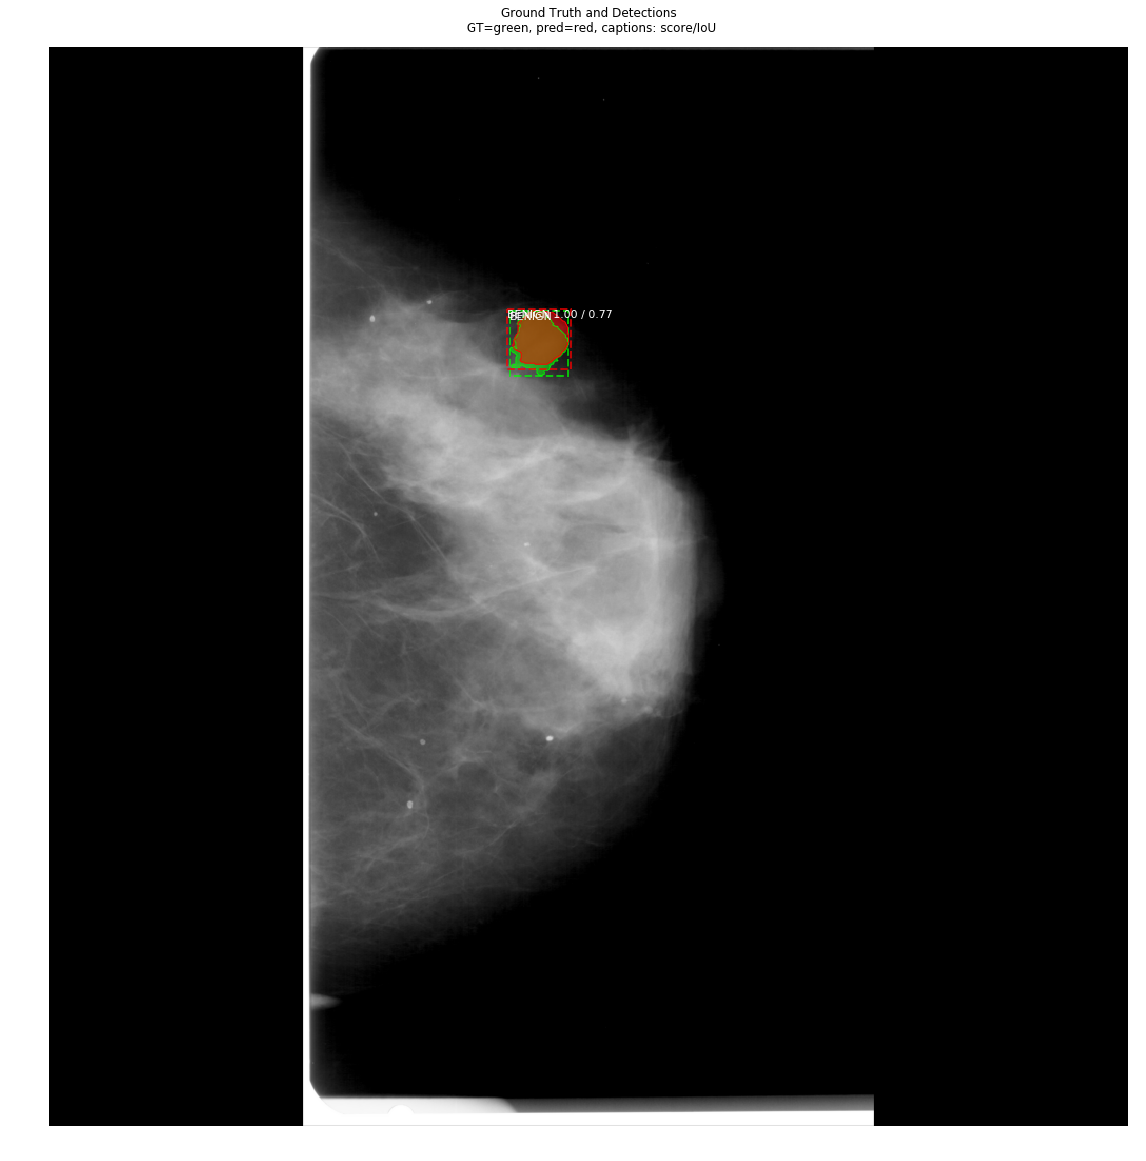

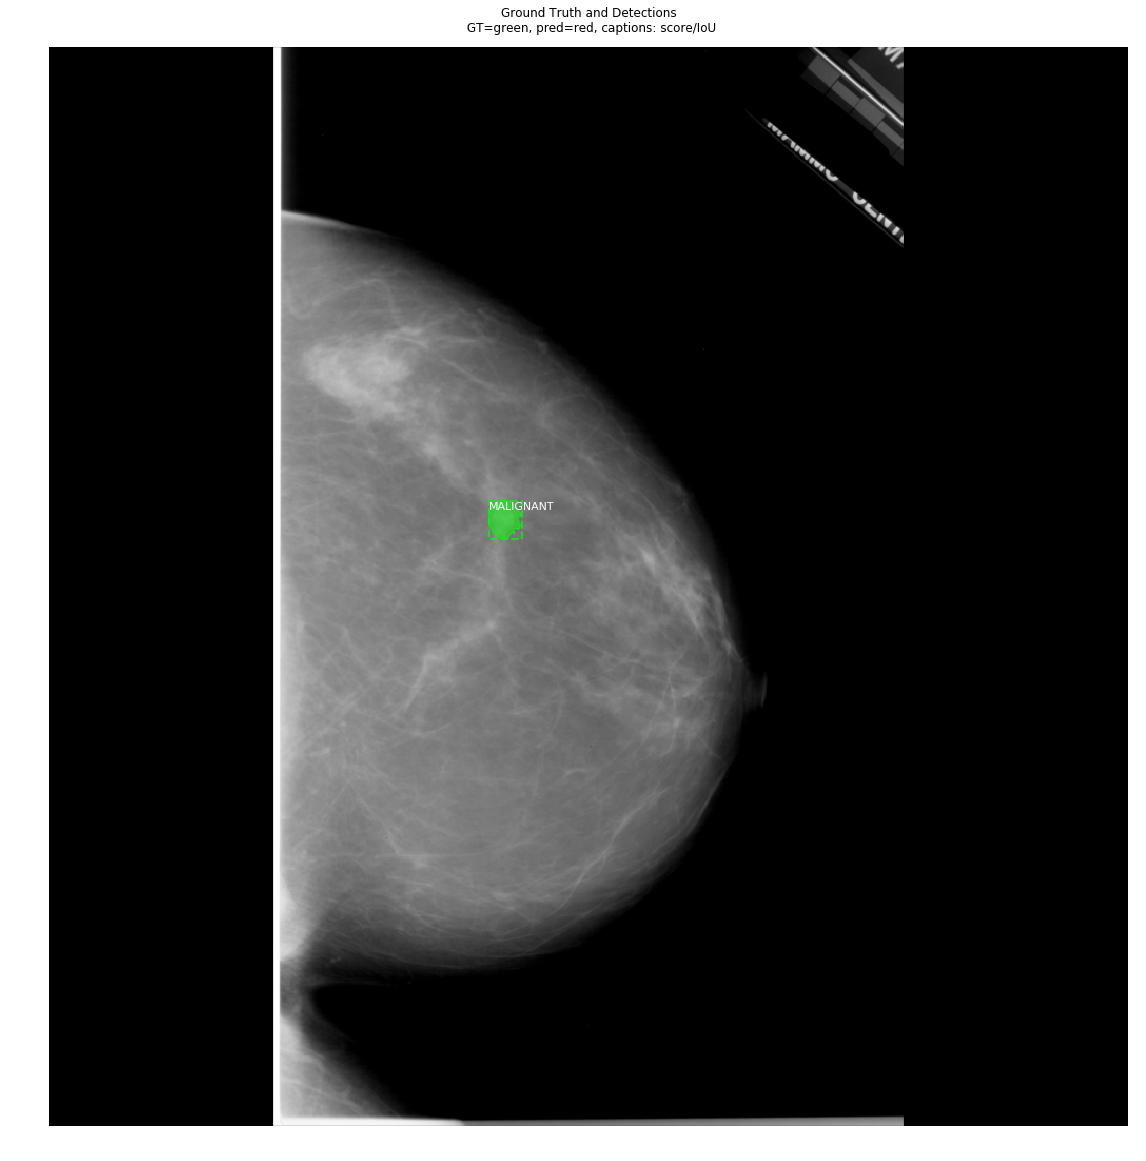

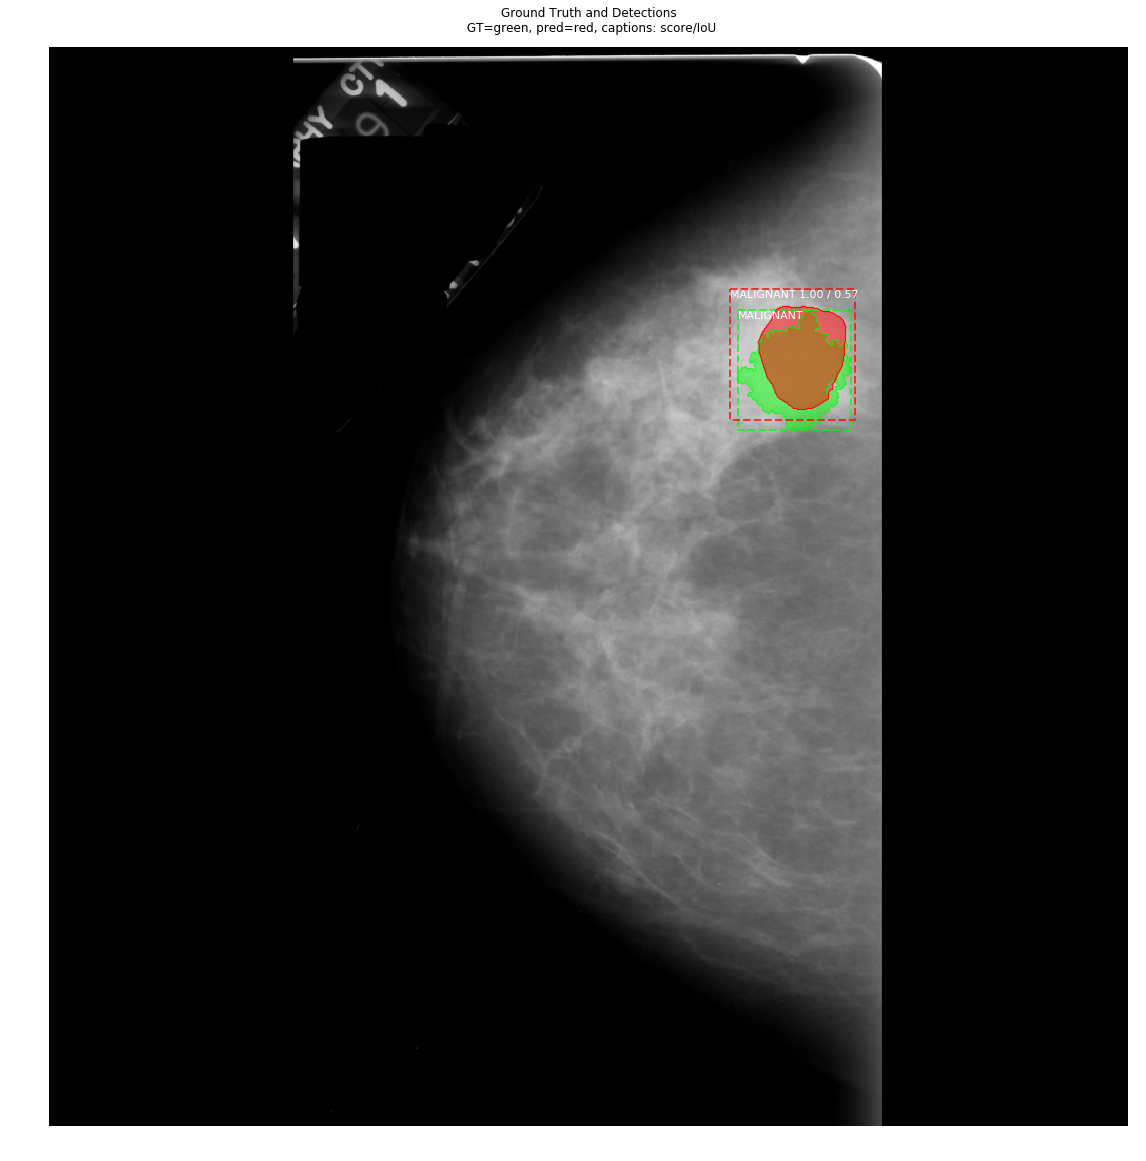

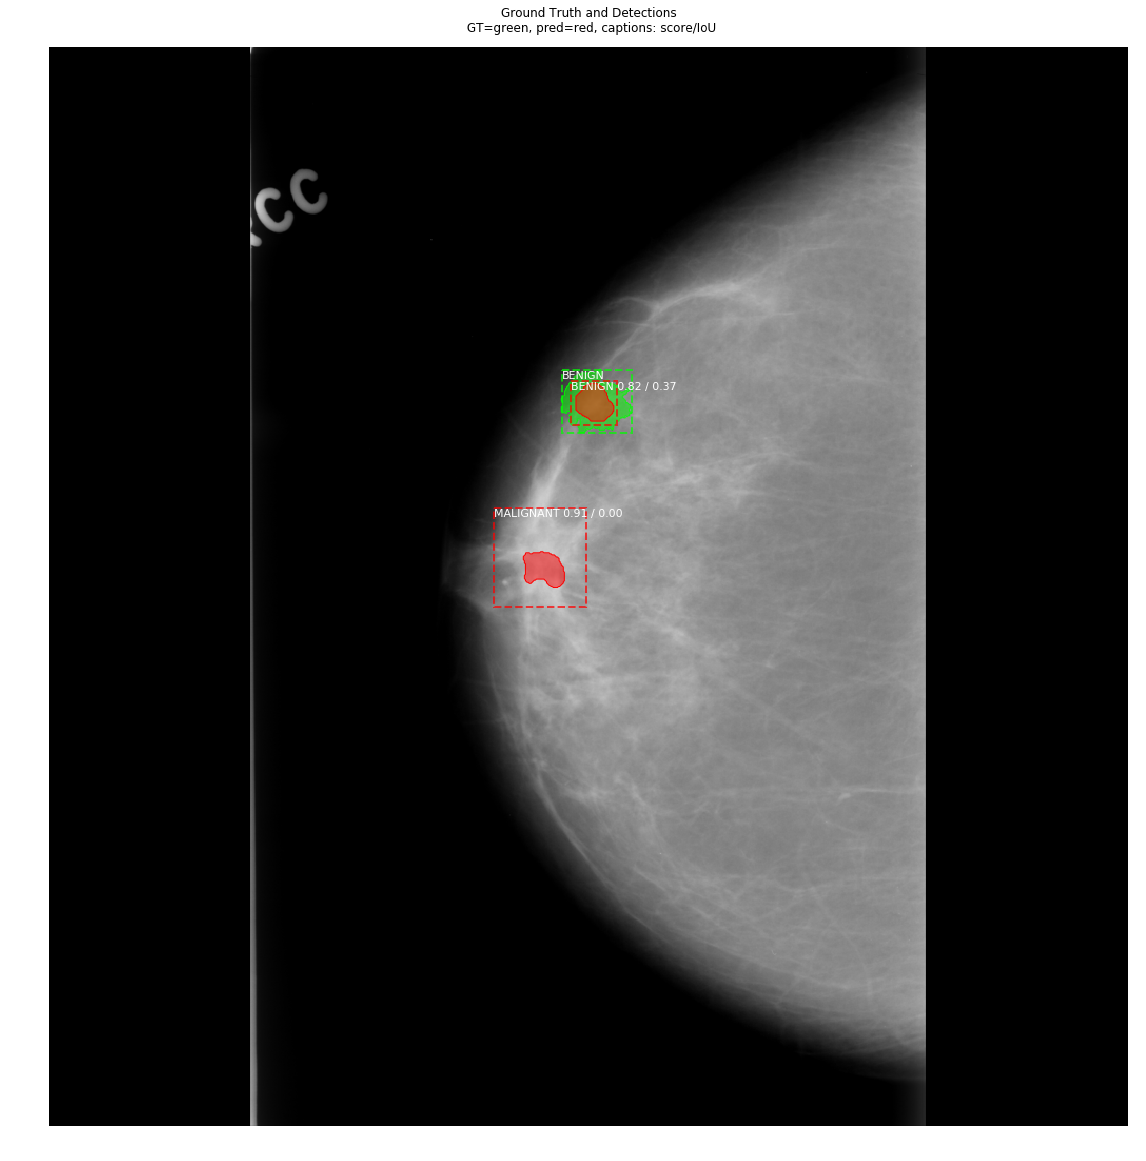

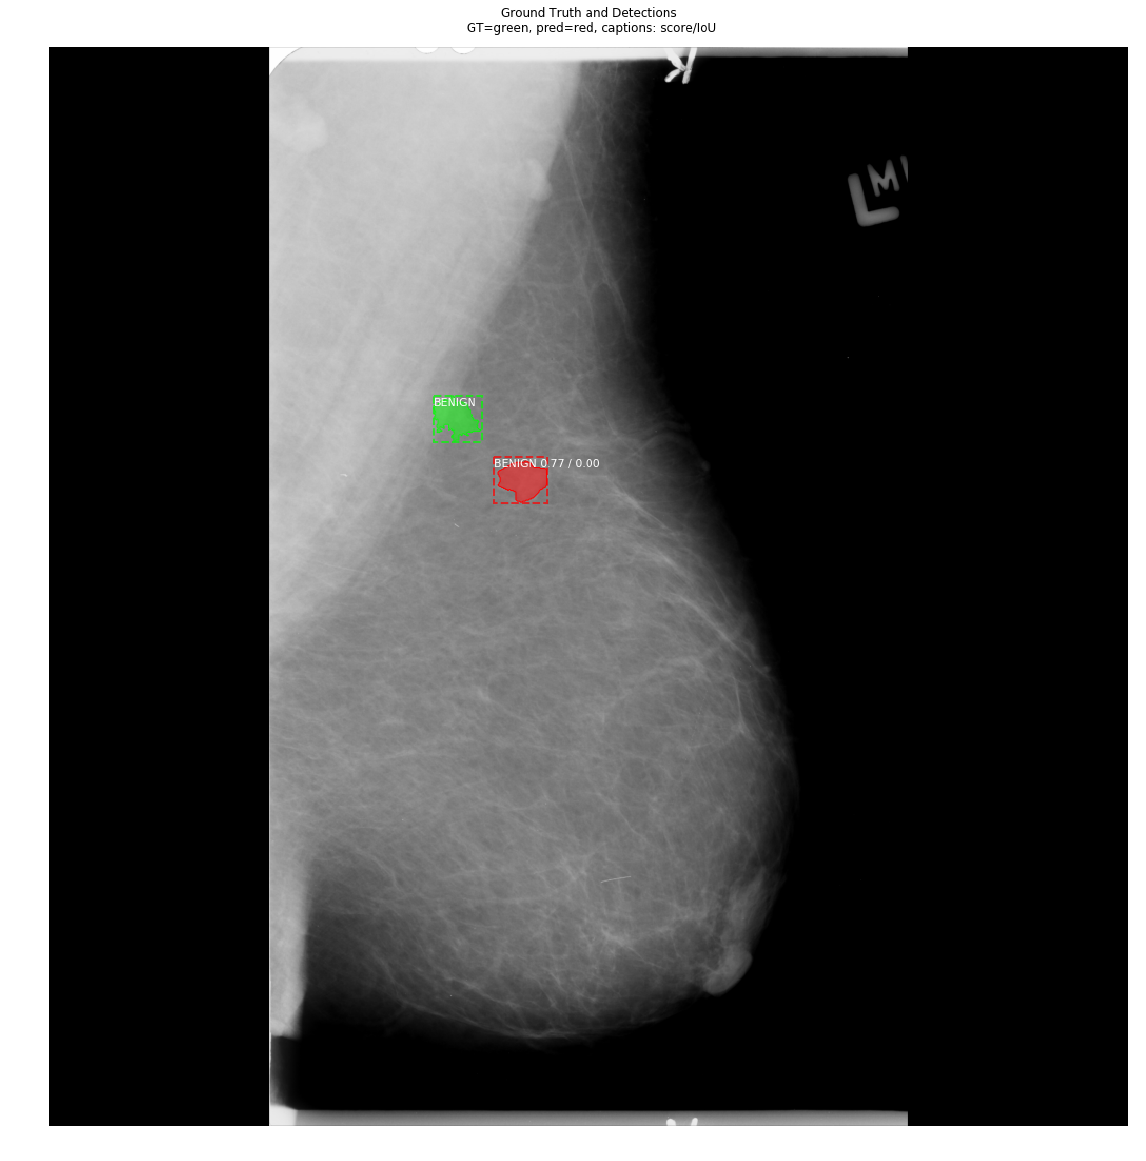

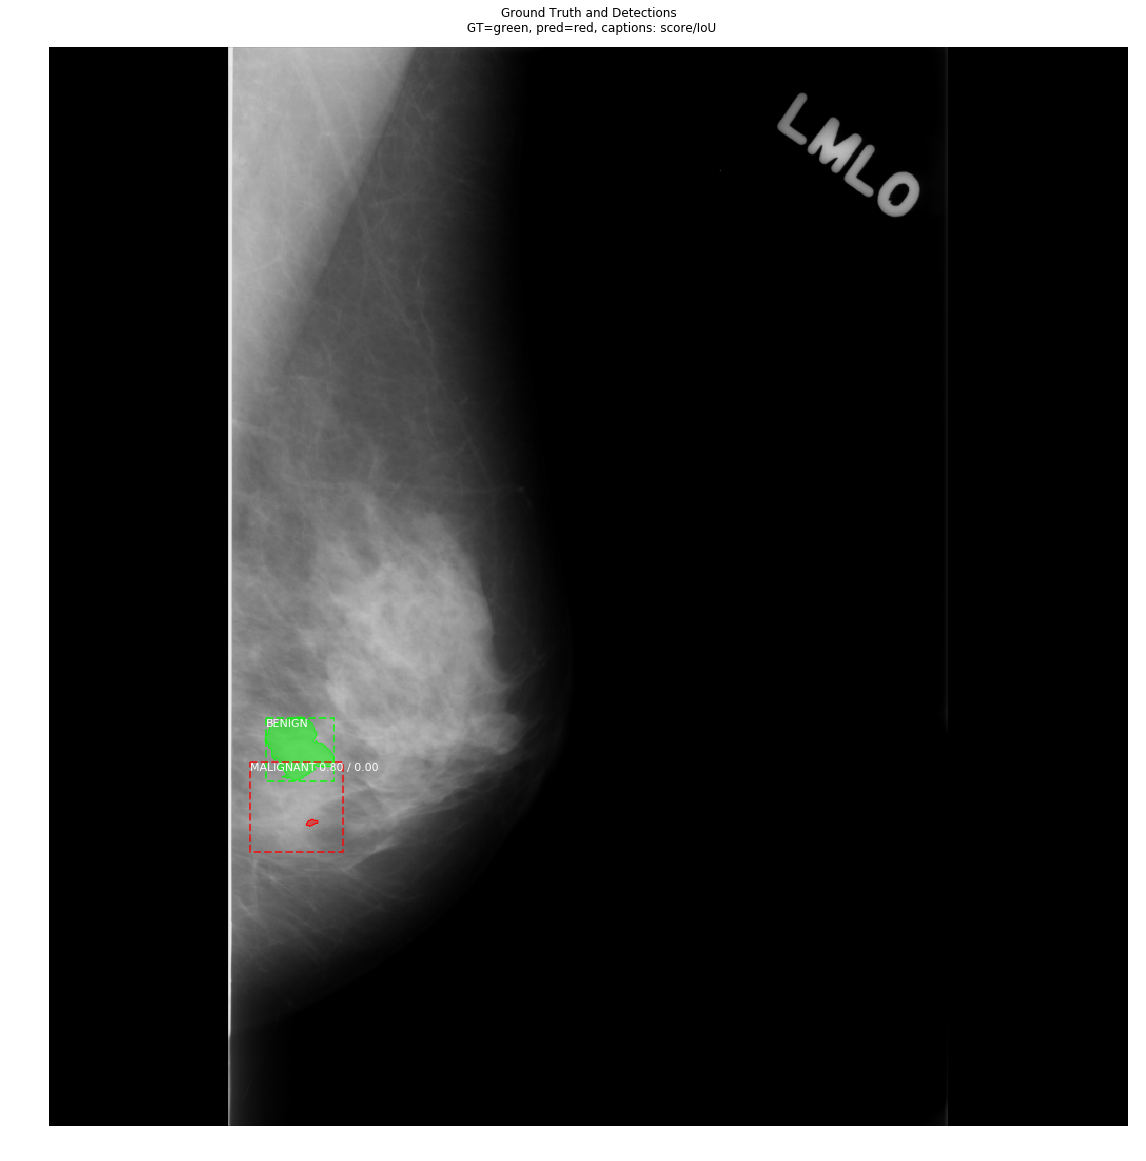

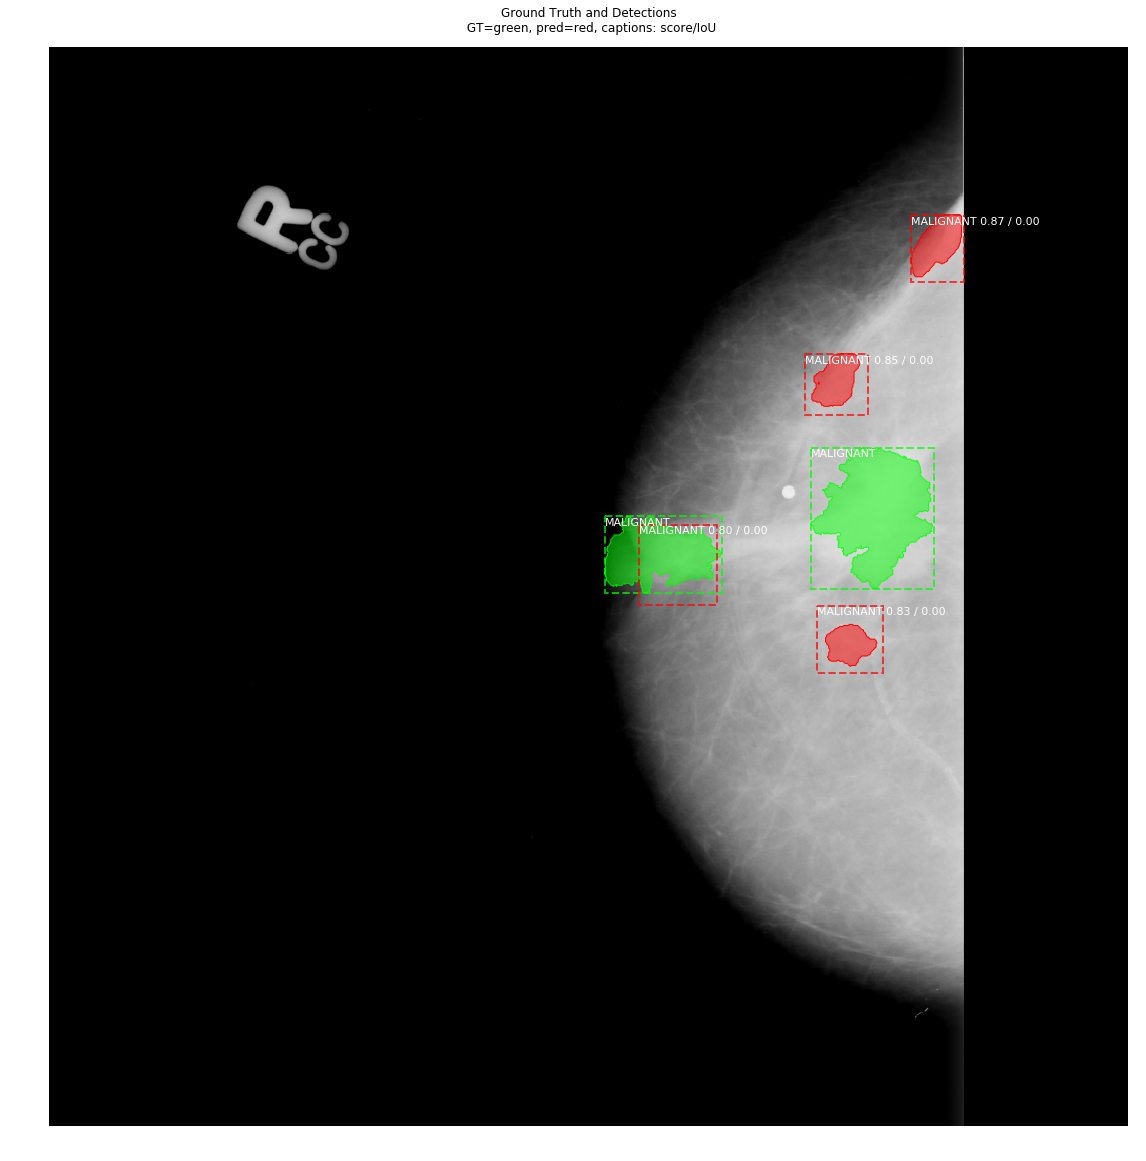

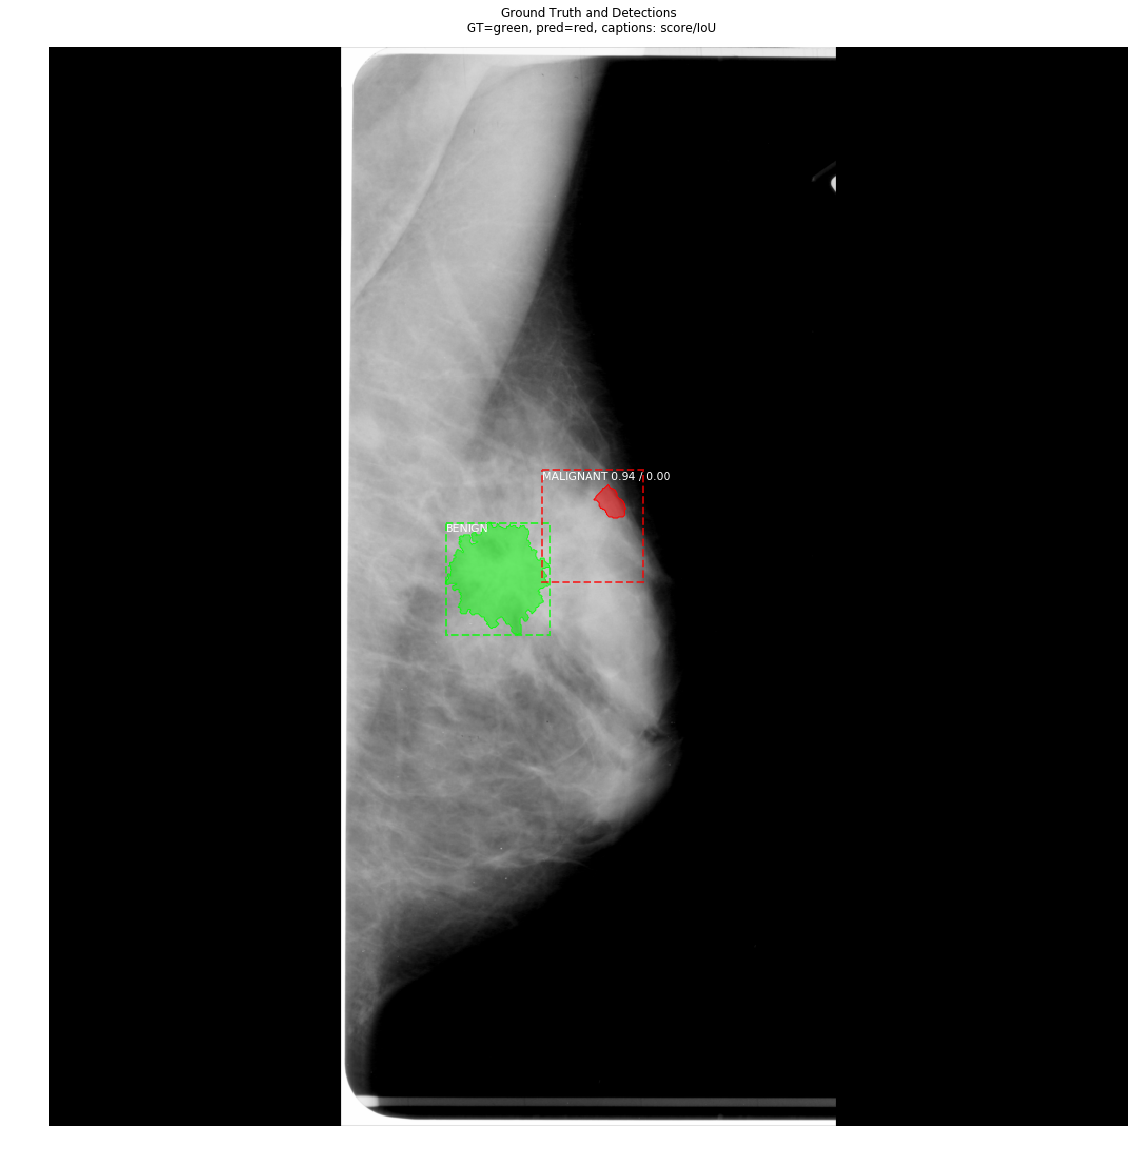

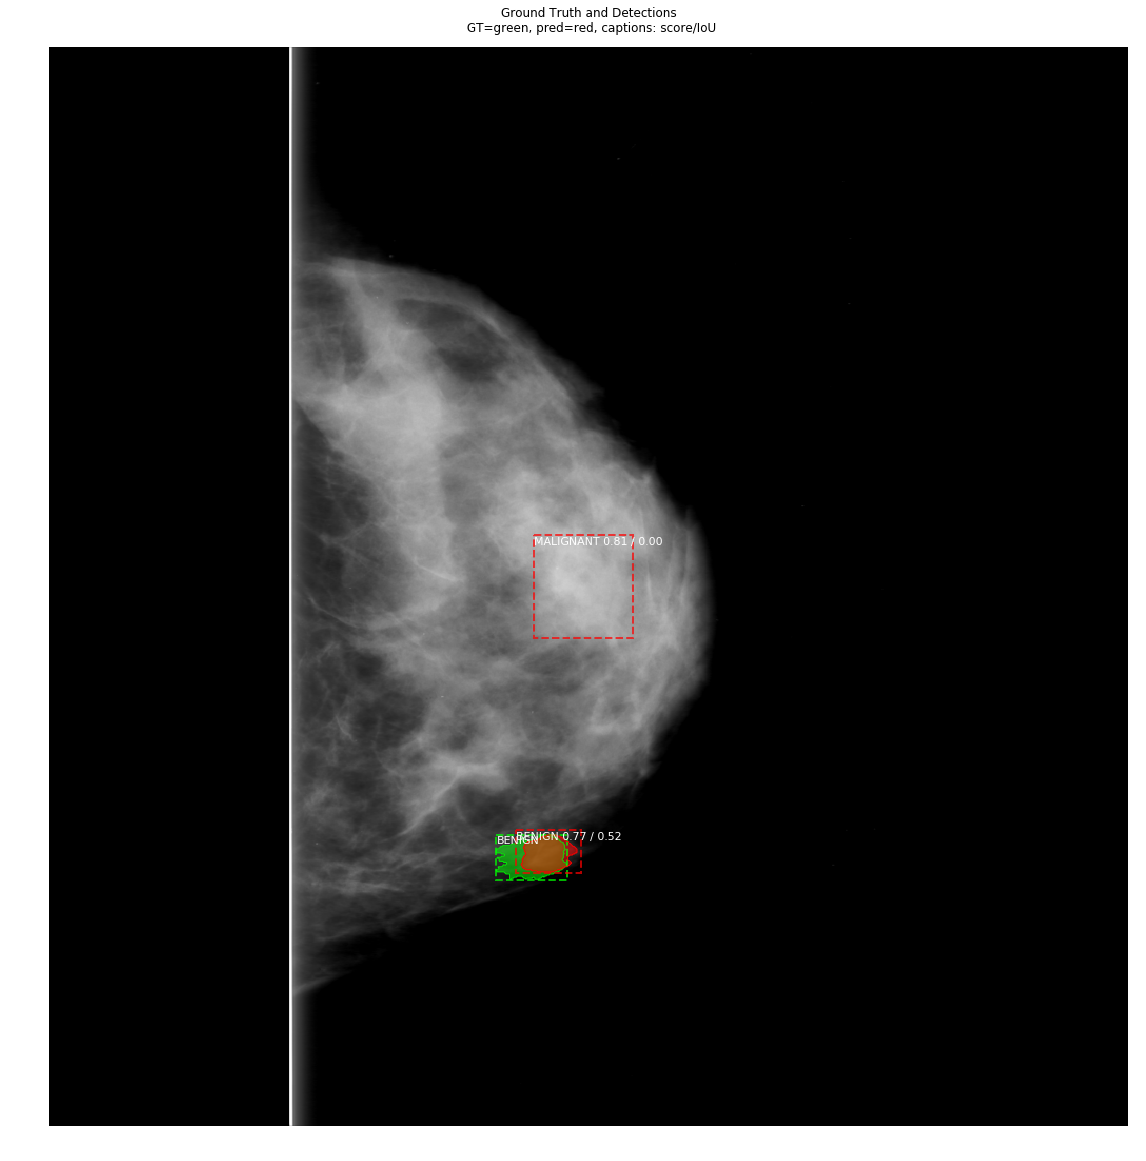

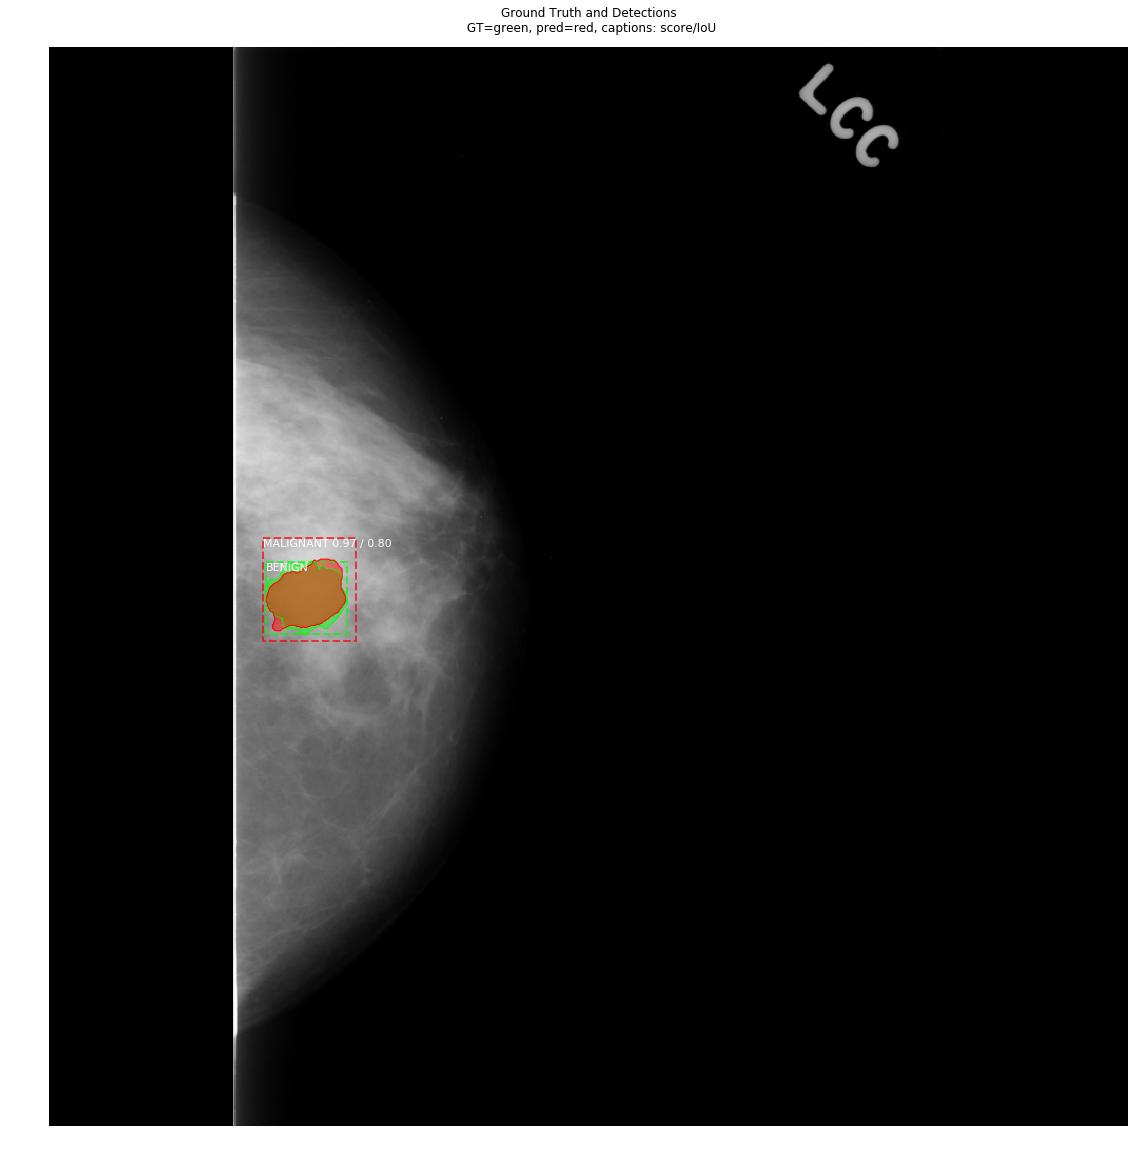

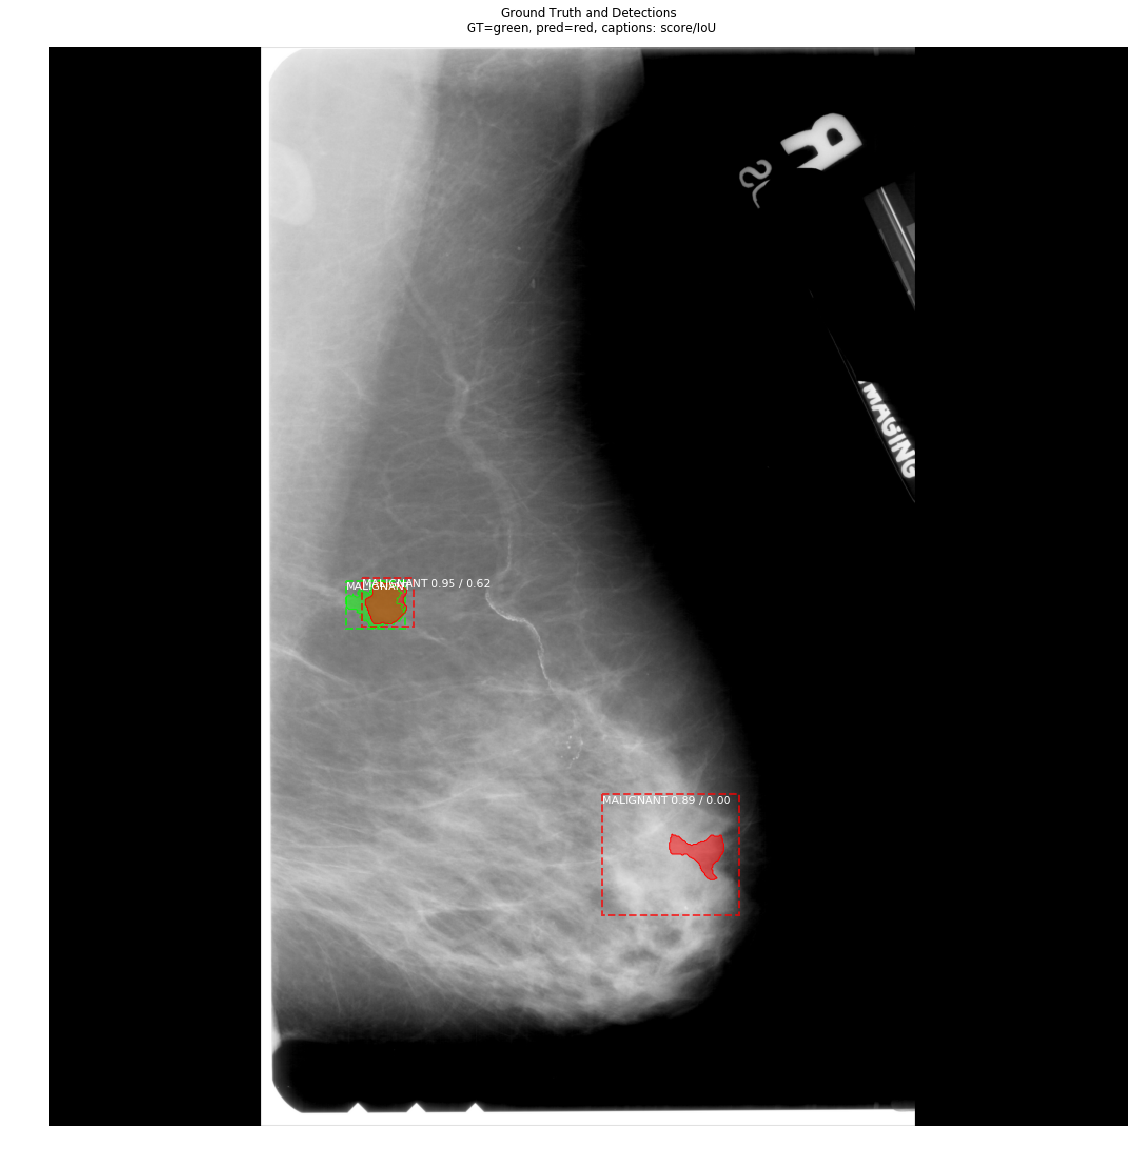

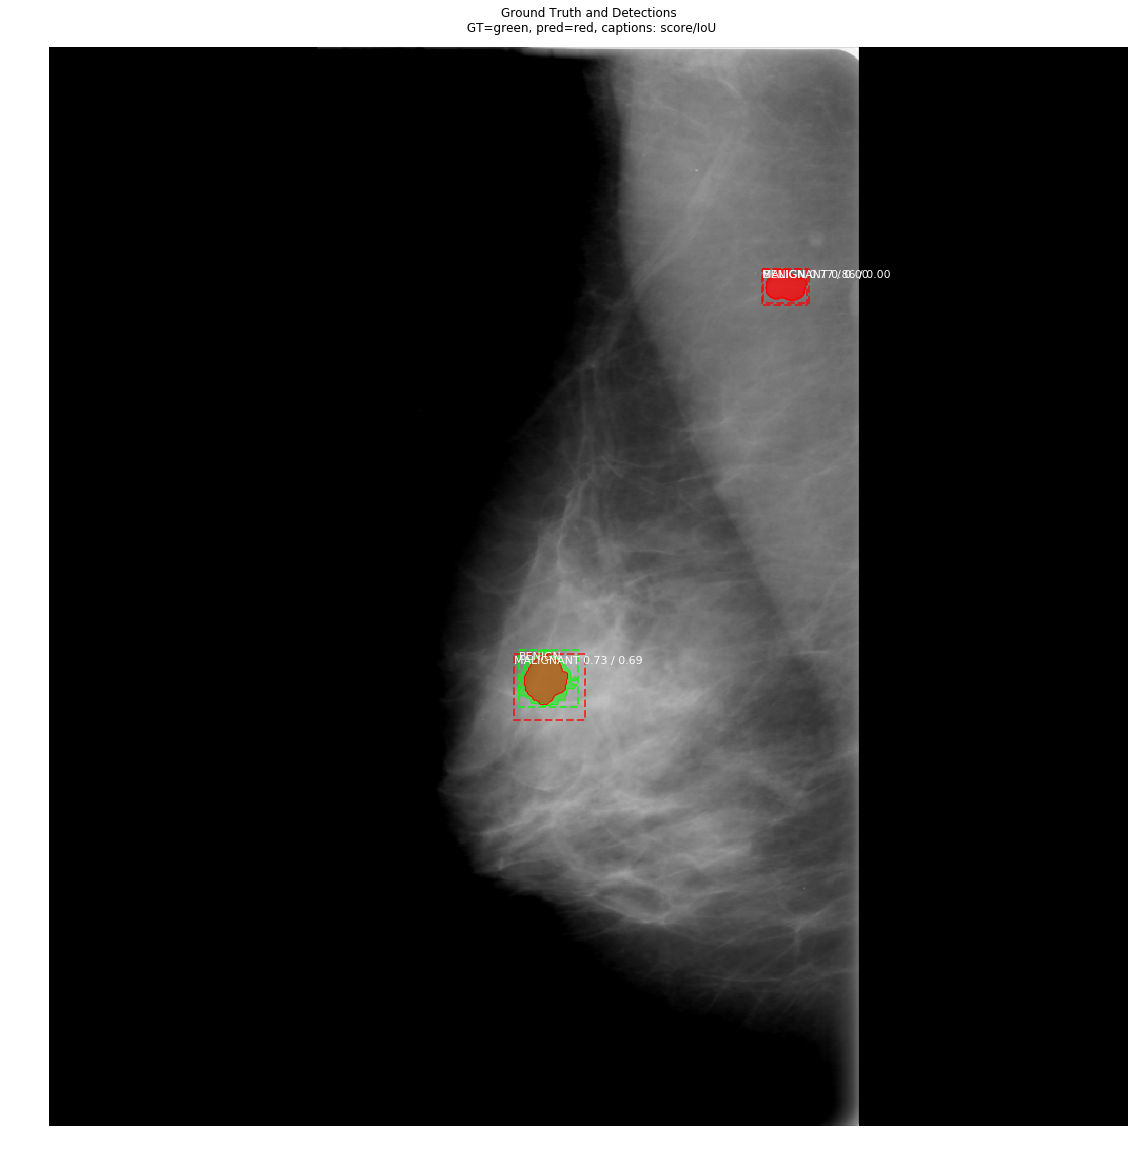

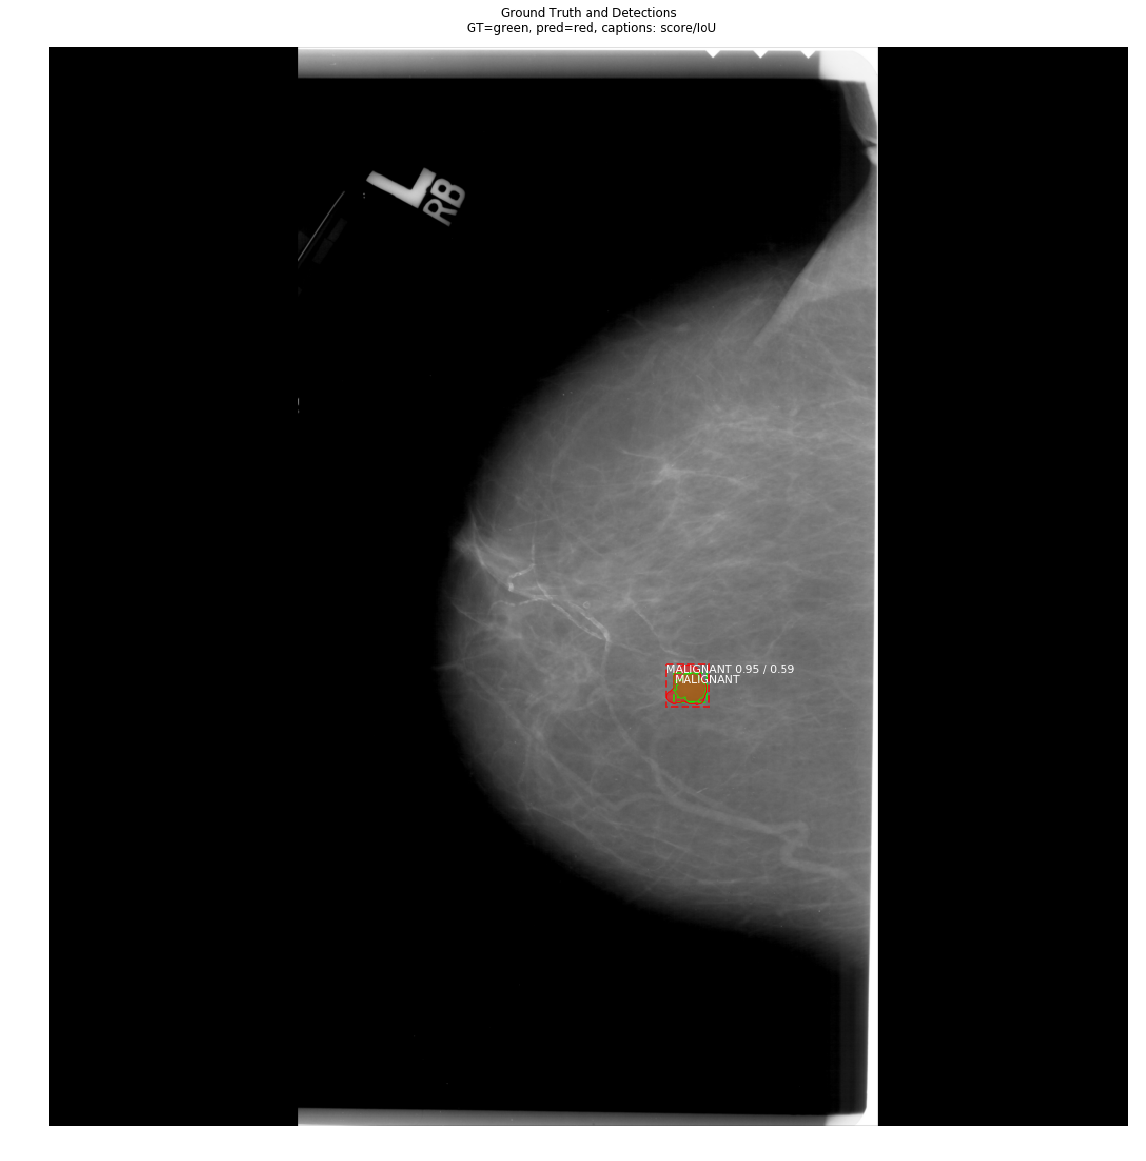

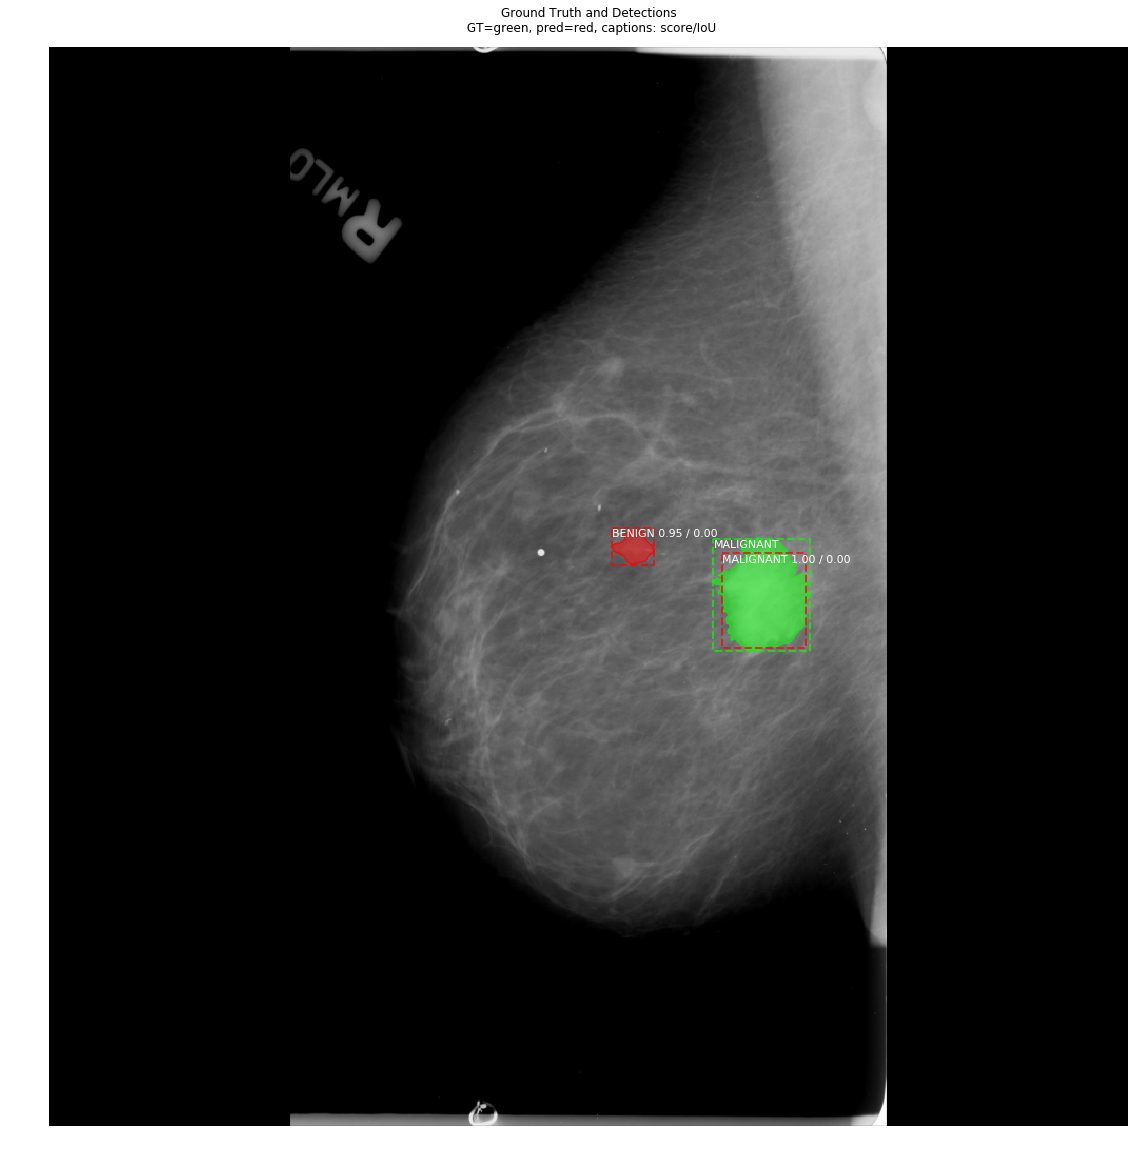

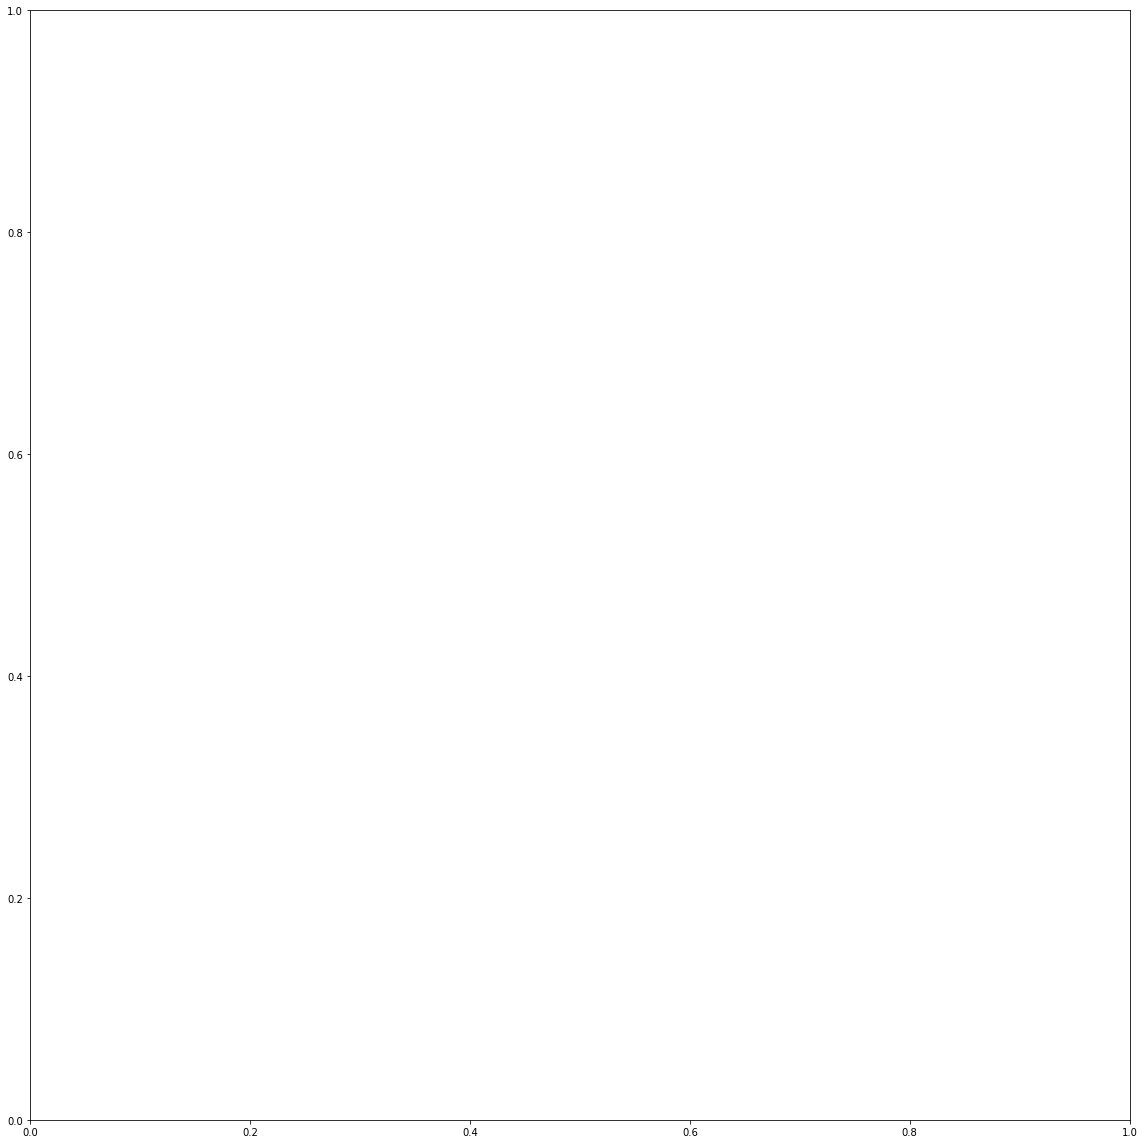

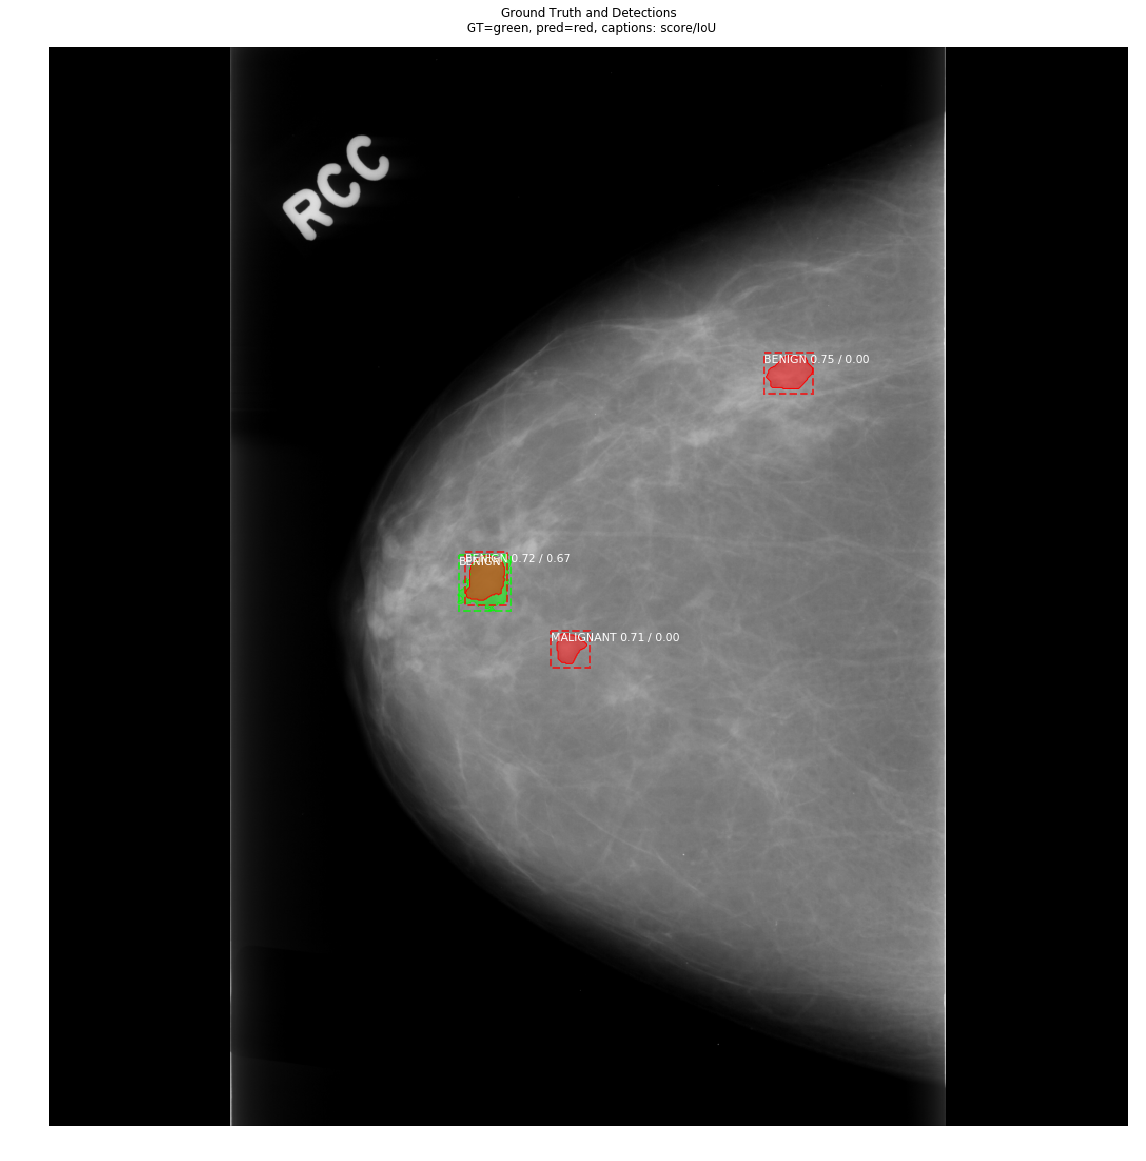

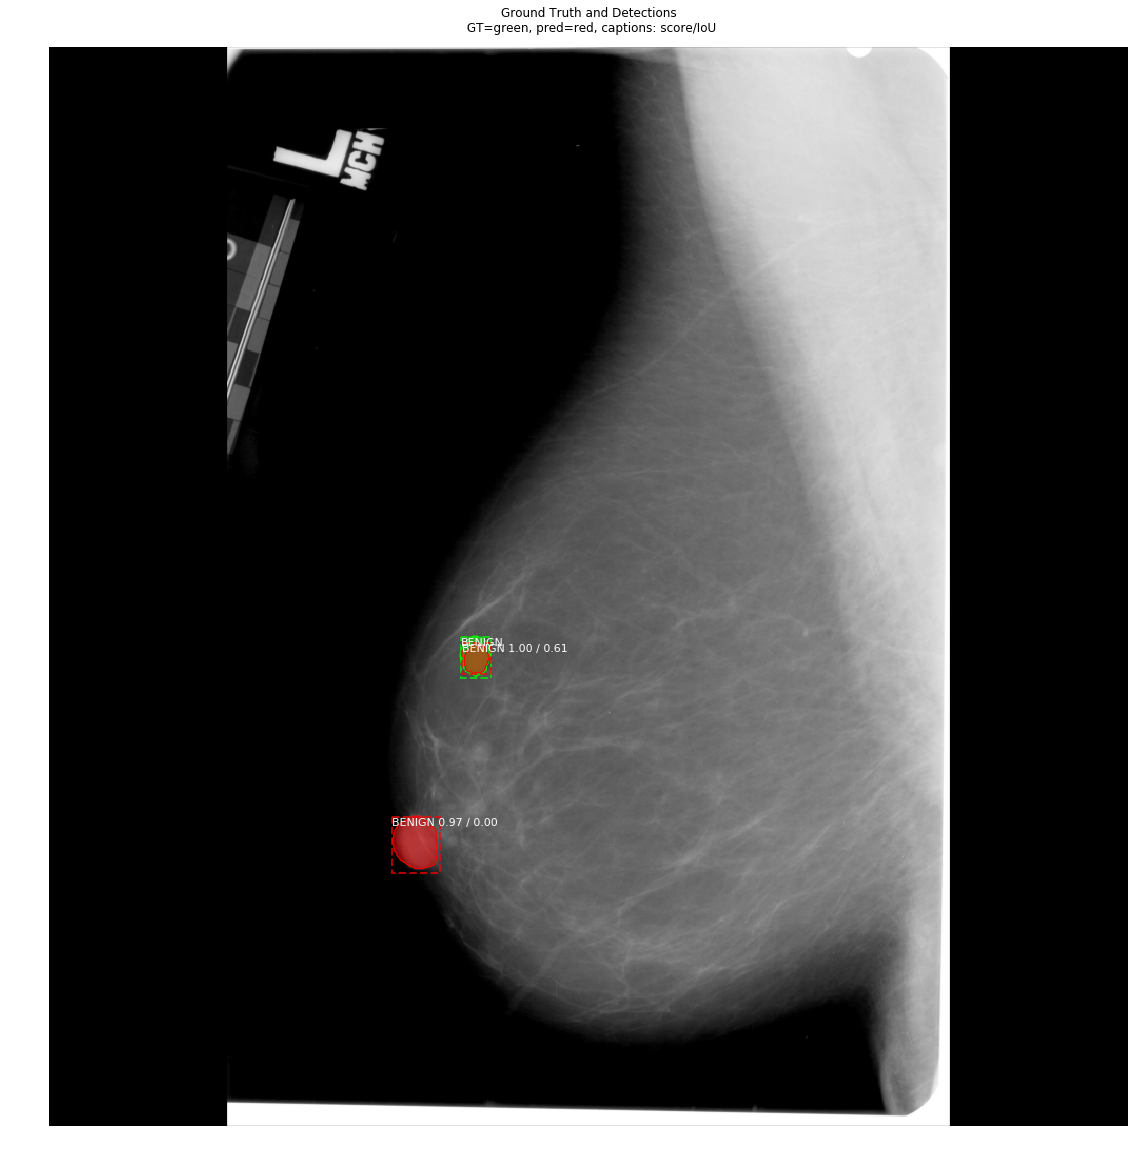

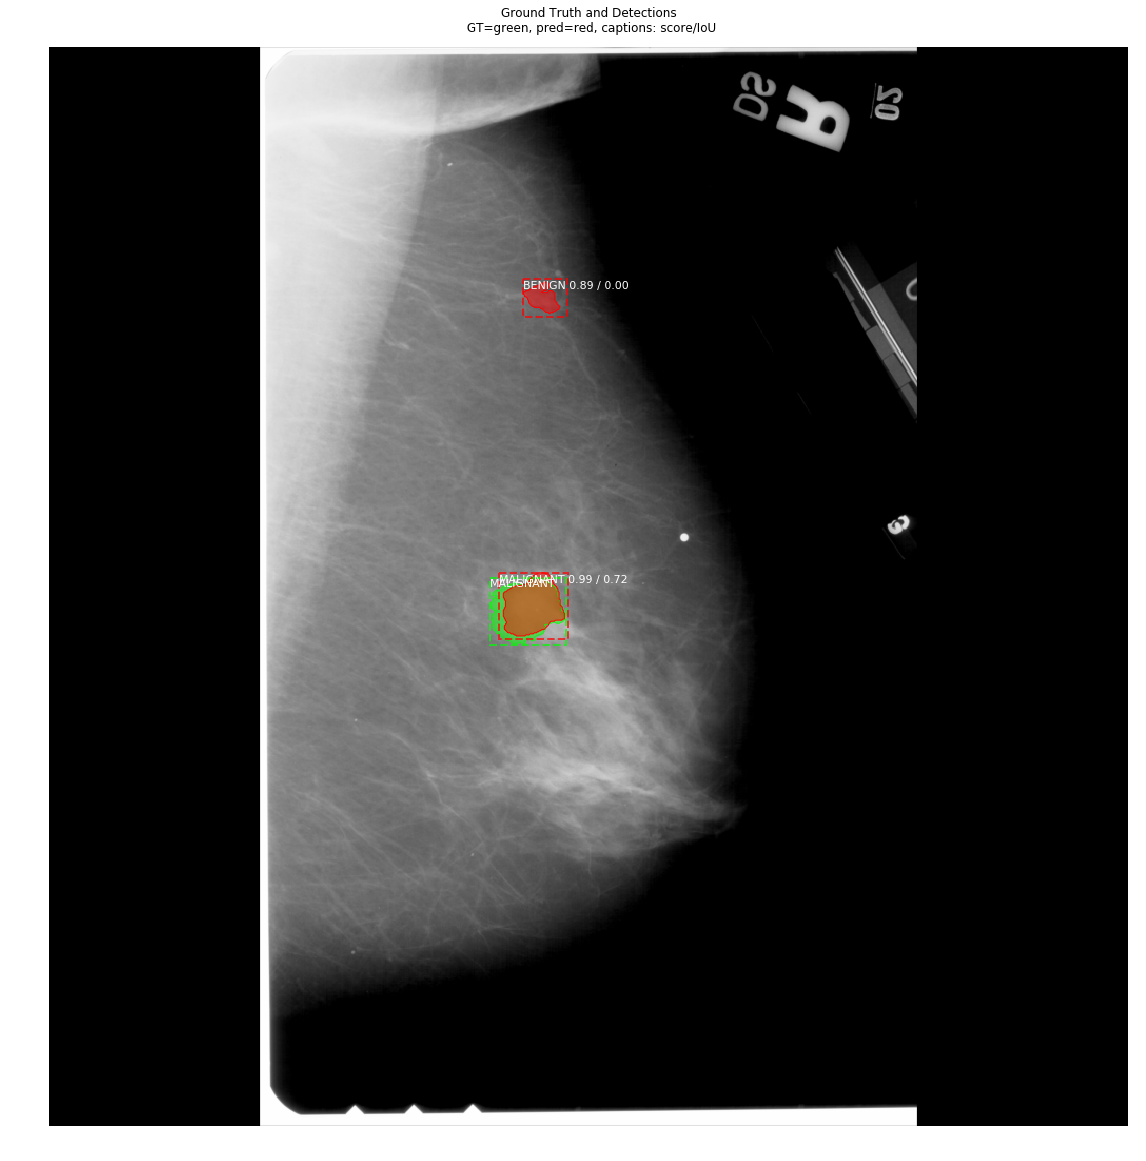

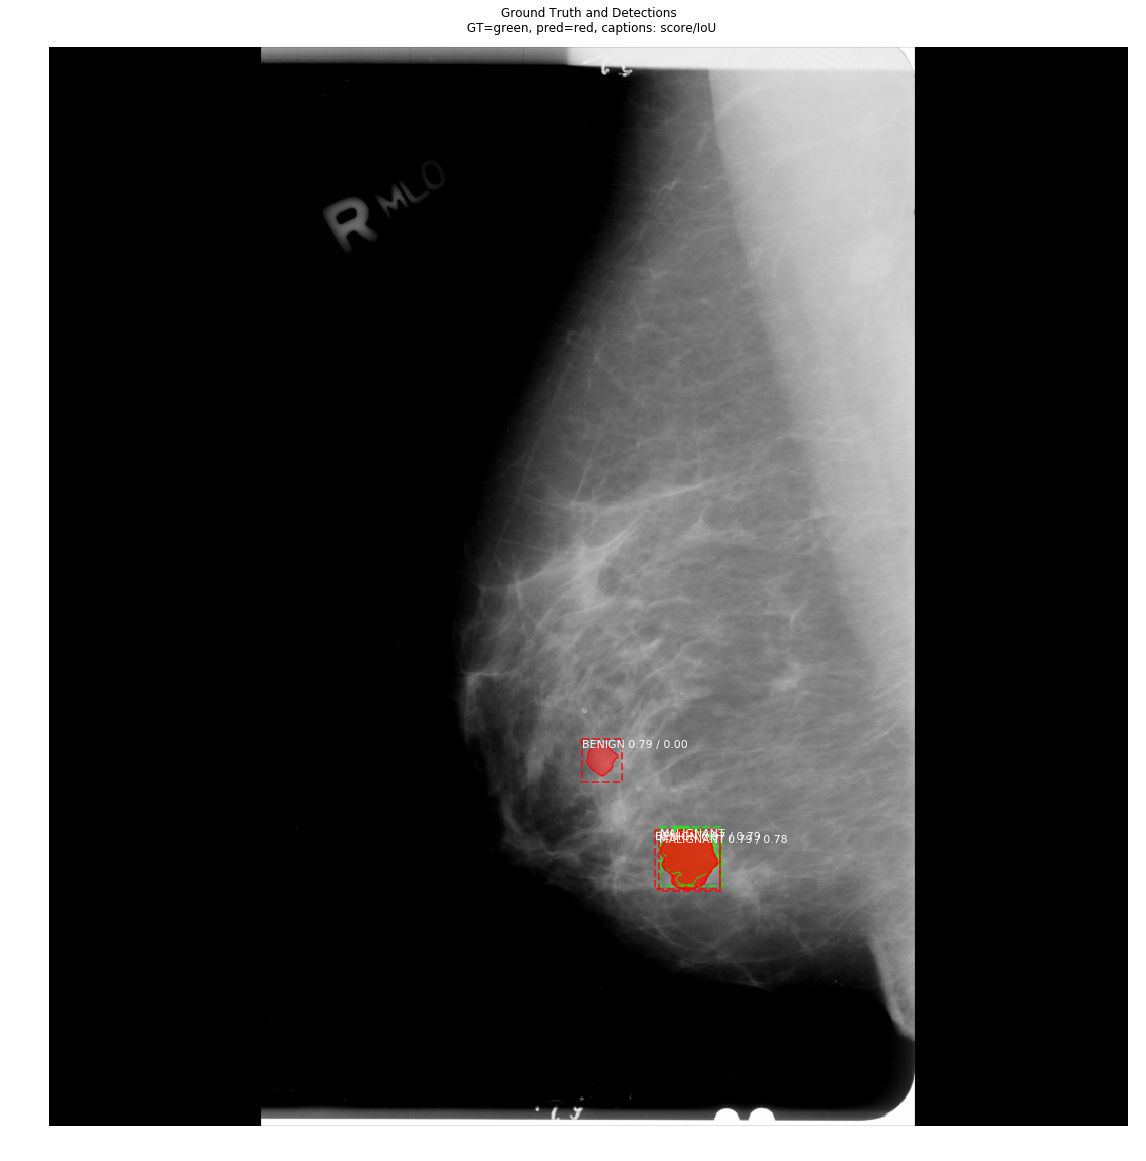

In [94]:
def visualize_result(gt_li, pred_li):
    cnt = 0
    for item in zip(gt_li, pred_li): # for one image
        gt, pred = item
        image, image_meta, gt_class_id, gt_bbox, gt_mask = gt
        
        results = pred
        r = results[0]
                
        cnt += 1
        # show differences
        if cnt < 20:
            try:
                visualize.display_differences(image, gt_bbox, gt_class_id, gt_mask, r['rois'], r['class_ids'], r['scores'], r['masks'],
                                      dataset.class_names, ax=get_ax(),show_box=True, show_mask=True,
                                      iou_threshold=0.1, score_threshold=0.9) # iou threshold =0.5
            except:
                print('visualization error')
                continue

visualize_result(gt_li, pred_li)

In [91]:
# using mammo_20/mass_train as test set:
# 0.875 (8, 1, 1, 4) 0.6578185048087367
# using mammo_all/mass_test as test set:
# cnt_mismatch: 13
# 0.7013698630136986 (95, 66, 23, 72) 0.5313377222728377

SyntaxError: invalid syntax (<ipython-input-91-73a50eb6926f>, line 1)

In [35]:
def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = np.zeros(8) # 10
    mAPs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=1) # verbose=0
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        iou = np.arange(0.1, 0.5, 0.05) ###
        mAP, AP = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
             iou_thresholds=iou,verbose=1) # verbose=0 iou=0.5
        mAPs.append(mAP)
        APs = np.add(APs, AP)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   mAP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], mAP))
    return mAPs,APs

# AP
limit = 16
iou_range = np.arange(0.5, 1.0, 0.05)
mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit],verbose=0) # 
for i in range(len(iou_range)):
    print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
    print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  213.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min:    0.00000  max:  213.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4951.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
AP @0.10:	 0.000
AP @0.15:	 0.000
AP @0.20:	 0.000
AP @0.25:	 0.000
AP @0.30:	 0.000
AP @0.35:	 0.000
AP @0.40:	 0.000
AP @0.45:	 0.000
AP @0.10-0.45:	 0.000
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4696.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
AP @0.10:	 0.000
AP @0.15:	 0.000
AP @0.20

AP @0.25:	 0.000
AP @0.30:	 0.000
AP @0.35:	 0.000
AP @0.40:	 0.000
AP @0.45:	 0.000
AP @0.10-0.45:	 0.000
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  247.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min:    0.00000  max:  247.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4504.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
AP @0.10:	 0.500
AP @0.15:	 0.500
AP @0.20:	 0.500
AP @0.25:	 0.500
AP @0.30:	 0.500
AP @0.35:	 0.500
AP @0.40:	 0.500
AP @0.45:	 0.500
AP @0.10-0.45:	 0.500
AP @0.50:	 0.406
Mean AP over 16 images: 0.3659
AP @0.55:	 0.375
Mean AP over 16 images: 0.3659
AP @0.60:	 0.375
Mean AP over 16 images: 0.3659
AP @0.65:	 0.375
Mean AP over 16 images: 0.3659
AP @0.70:	 0.365
Mean AP over 16 images: 0.3659
AP @0.75:	 0.344
Mean AP over 16 images: 0.3659
AP @0.80:	 0.344
Mean AP over 16 images: 0.3659

IndexError: index 8 is out of bounds for axis 0 with size 8